<a href="https://colab.research.google.com/drive/1sHyV7_vpvmBiGyK5BkviyPq6YSw3a2r9?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



By [Ibrahim Sobh](https://www.linkedin.com/in/ibrahim-sobh-phd-8681757/)

# Image classification with MLP-Mixer and ViT Hybrid models

## Setup and basic code

In [ ]:
!pip install -U tensorflow-addons

     |████████████████████████████████| 1.1 MB 5.3 MB/s 


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow

### Data

In [ ]:
num_classes = 10
input_shape = (32, 32, 3)
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

170508288/170498071 [==============================] - 2s 0us/step
x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


In [ ]:
# scale data
x_train = x_train / 255.0
x_test = x_test / 255.0

### Model

In [ ]:
weight_decay = 0.0001
batch_size = 128
num_epochs = 50
dropout_rate = 0.2
image_size = 64 # resize input images to this size.
patch_size = 8  # Size of the patches to be extracted from the input images.
num_patches = (image_size // patch_size) ** 2  # Size of the data array.
embedding_dim = 256  # Number of hidden units.
num_blocks = 4  # Number of blocks.

print(f"Image size: {image_size} X {image_size} = {image_size ** 2}")
print(f"Patch size: {patch_size} X {patch_size} = {patch_size ** 2} ")
print(f"Patches per image: {num_patches}")
print(f"Elements per patch (3 channels): {(patch_size ** 2) * 3}")

Image size: 64 X 64 = 4096
Patch size: 8 X 8 = 64 
Patches per image: 64
Elements per patch (3 channels): 192


In [ ]:
def build_classifier(blocks, positional_encoding=False):
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size, num_patches)(augmented)
    # Encode patches to generate a [batch_size, num_patches, embedding_dim] tensor.
    x = layers.Dense(units=embedding_dim)(patches)
    if positional_encoding:
      print("positional_encoding= ", positional_encoding)
      positions = tf.range(start=0, limit=num_patches, delta=1)
      position_embedding = layers.Embedding(
          input_dim=num_patches, output_dim=embedding_dim #, trainable=True
      )(positions)
      x = x + position_embedding
    # Process x using the module blocks.
    x = blocks(x)
    # Apply global average pooling to generate a [batch_size, embedding_dim] representation tensor.
    representation = layers.GlobalAveragePooling1D()(x)
    # Apply dropout.
    representation = layers.Dropout(rate=dropout_rate)(representation)
    # Compute logits outputs.
    logits = layers.Dense(num_classes)(representation)
    # Create the Keras model.
    return keras.Model(inputs=inputs, outputs=logits)

In [ ]:
def run_experiment(model):
    # Create Adam optimizer with weight decay.
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay,
    )
    # Compile the model.
    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="acc")
        ],
    )
    # Create a learning rate scheduler callback.
    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=5
    )
    # Create an early stopping callback.
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=10, restore_best_weights=True
    )
    # Fit the model.
    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[early_stopping, reduce_lr],
    )

    _, accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    # Return history to plot learning curves.
    return history


In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

In [ ]:
# patch extraction as a layer
class Patches(layers.Layer):
    def __init__(self, patch_size, num_patches):
        super(Patches, self).__init__()
        self.patch_size = patch_size
        self.num_patches = num_patches

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, self.num_patches, patch_dims])
        return patches

### Plot

In [ ]:
def plot_curves(history, lossname='loss', accname='acc'):
    plt.figure(figsize=(10, 7))
    plt.plot(history.history[lossname], label='Train')
    plt.plot(history.history['val_' + lossname], label='Val')
    plt.title('Learning curve')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.grid()
    plt.legend()
    plt.show()
    print()
    plt.figure(figsize=(10, 7))
    plt.plot(history.history[accname], label='Train')
    plt.plot(history.history['val_' + accname], label='Val')
    plt.title('Learning curve')
    plt.ylabel('acc')
    plt.xlabel('Epoch')
    plt.grid()
    plt.legend()
    plt.show()
    print()


def print_exp_params():
    print("num_epochs: ", num_epochs)
    print("embedding_dim: ", embedding_dim)
    print("batch_size: ", batch_size)
    print("num_blocks: ", num_blocks)
    print("dropout_rate: ", dropout_rate)
    print("learning_rate: ", learning_rate)
    print("-"*30)

## MLP-Mixer model

Based on the paper [MLP-Mixer: An all-MLP Architecture for Vision](https://arxiv.org/abs/2105.01601), keras code [code](https://github.com/keras-team/keras-io/blob/master/examples/vision/mlp_image_classification.py)<br>

- "While convolutions and attention are both sufficient for good performance, neither of them is necessary!"
- "Mixer is a competitive but conceptually and technically simple alternative, that does not use convolutions or self-attention"
- "The idea behind the Mixer architecture is to clearly separate the per-location (channel-mixing) operations, and cross-location (token-mixing) operations. Both operations are implemented with MLPs"
- "Mixer relies only on basic matrix multiplication routines, changes to data layout (reshapes and transpositions), and scalar nonlinearities."
- "The computational complexity of the network is linear in the number of input patches, unlike ViT whose complexity is quadratic"
- "Each layer in Mixer takes an input of the same size. This “isotropic” design is most similar to Transformers"
- "Unlike ViTs, Mixer does not use position embeddings because the token-mixing MLPs are sensitive to the order of the input tokens."

The MLP-Mixer model tends to have much less number of parameters compared
to convolutional and transformer-based models, which leads to less training and
serving computational cost.

https://keras.io/examples/vision/mlp_image_classification/#the-mlpmixer-model


### The original MLP-Mixer module
> If the input to the layer has a rank greater than 2, then Dense computes the dot product between the inputs and the kernel along the last axis of the inputs and axis 0 of the kernel (using tf.tensordot). 
- For example, if input has dimensions (batch_size, d0, d1), then we create a kernel with shape (d1, units), and the kernel operates along axis 2 of the input, on every sub-tensor of shape (1, 1, d1) (there are batch_size * d0 such sub-tensors). The output in this case will have shape (batch_size, d0, units).

 https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense

In [ ]:
# Original paper
class MLPMixerLayer(layers.Layer):
    def __init__(self, num_patches, hidden_units, dropout_rate, *args, **kwargs):
        super(MLPMixerLayer, self).__init__(*args, **kwargs)

        self.mlp1 = keras.Sequential(
            [
                layers.Dense(units=num_patches),
                tfa.layers.GELU(),
                layers.Dense(units=num_patches),
                layers.Dropout(rate=dropout_rate),
            ]
        )
        self.mlp2 = keras.Sequential(
            [
                layers.Dense(units=num_patches),
                tfa.layers.GELU(),
                layers.Dense(units=embedding_dim),
                layers.Dropout(rate=dropout_rate),
            ]
        )
        self.normalize = layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs):
        # Apply layer normalization.
        x = self.normalize(inputs)
        # Transpose inputs from [num_batches, num_patches, hidden_units] to [num_batches, hidden_units, num_patches].
        x_channels = tf.linalg.matrix_transpose(x)
        # Apply mlp1 on each channel independently.
        mlp1_outputs = self.mlp1(x_channels)
        # Transpose mlp1_outputs from [num_batches, hidden_dim, num_patches] to [num_batches, num_patches, hidden_units].
        mlp1_outputs = tf.linalg.matrix_transpose(mlp1_outputs)
        # Add skip connection.
        x = mlp1_outputs + inputs
        # Apply layer normalization.
        x_patches = self.normalize(x)
        # Apply mlp2 on each patch independtenly.
        mlp2_outputs = self.mlp2(x_patches)
        # Add skip connection.
        x = x + mlp2_outputs
        return x


In [ ]:
num_epochs = 50
embedding_dim = 128
batch_size = 128
num_blocks = 2
dropout_rate = 0.2
mlpmixer_blocks = keras.Sequential([MLPMixerLayer(num_patches, embedding_dim, dropout_rate) for _ in range(num_blocks)])
learning_rate = 0.005
mlpmixer_classifier = build_classifier(mlpmixer_blocks)
mlpmixer_classifier.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
data_augmentation (Sequentia (None, 64, 64, 3)         7         
_________________________________________________________________
patches (Patches)            (None, 64, 192)           0         
_________________________________________________________________
dense_8 (Dense)              (None, 64, 128)           24704     
_________________________________________________________________
sequential_4 (Sequential)    (None, 64, 128)           50304     
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0     

In [ ]:
history = run_experiment(mlpmixer_classifier)

Epoch 1/50
352/352 [==============================] - 18s 35ms/step - loss: 1.6843 - acc: 0.3882 - val_loss: 1.4911 - val_acc: 0.4670
Epoch 2/50
352/352 [==============================] - 12s 33ms/step - loss: 1.4240 - acc: 0.4820 - val_loss: 1.2897 - val_acc: 0.5298
Epoch 3/50
352/352 [==============================] - 12s 33ms/step - loss: 1.3404 - acc: 0.5148 - val_loss: 1.3123 - val_acc: 0.5244
Epoch 4/50
352/352 [==============================] - 12s 33ms/step - loss: 1.2736 - acc: 0.5420 - val_loss: 1.1625 - val_acc: 0.5804
Epoch 5/50
352/352 [==============================] - 12s 33ms/step - loss: 1.2207 - acc: 0.5617 - val_loss: 1.1481 - val_acc: 0.5856
Epoch 6/50
352/352 [==============================] - 12s 33ms/step - loss: 1.1706 - acc: 0.5777 - val_loss: 1.1525 - val_acc: 0.5930
Epoch 7/50
352/352 [==============================] - 12s 33ms/step - loss: 1.1396 - acc: 0.5919 - val_loss: 1.1104 - val_acc: 0.6028
Epoch 8/50
352/352 [==============================] - 12s 33ms

num_epochs:  50
embedding_dim:  128
batch_size:  128
num_blocks:  2
dropout_rate:  0.2
learning_rate:  0.005
------------------------------


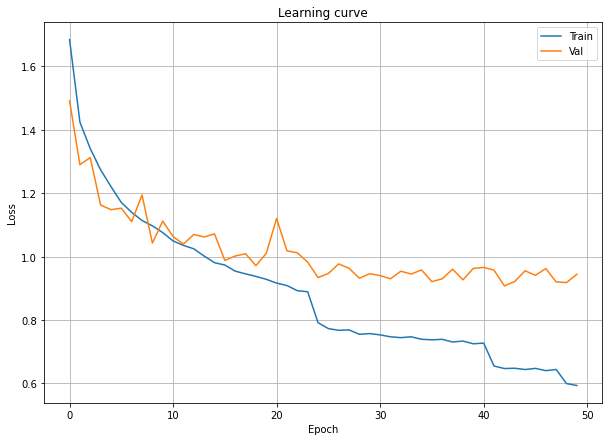

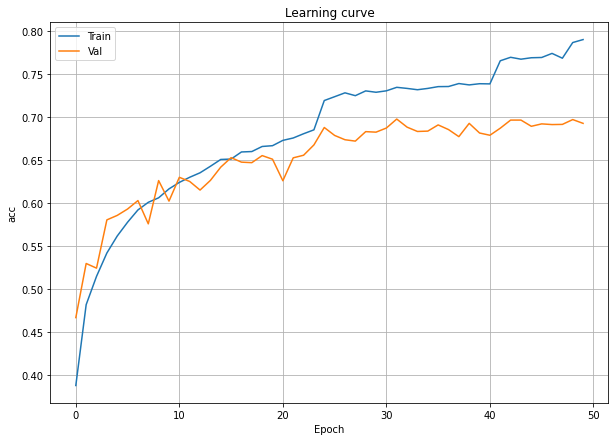

In [ ]:
print_exp_params()
plot_curves(history)

## ViT model

Based on the paper [An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale](https://arxiv.org/abs/2010.11929), keras code [code](https://github.com/keras-team/keras-io/blob/master/examples/vision/image_classification_with_vision_transformer.py)<br>

> We show that this reliance on CNNs is not necessary and a pure transformer applied directly to sequences of image patches can perform very well on image classification tasks.

> The ViT model applies the Transformer architecture with self-attention to sequences of image patches, without convolution layers.

### ViT: 1 layer

In [ ]:
class ViTLayer(layers.Layer):
    def __init__(self, num_patches, embedding_dim, dropout_rate, *args, **kwargs):
        super(ViTLayer, self).__init__(*args, **kwargs)

        self.mlp = keras.Sequential(
            [
                layers.Dense(units=64),
                tfa.layers.GELU(),
                layers.Dropout(rate=0.1),
                layers.Dense(units=embedding_dim),
                tfa.layers.GELU(),
                layers.Dropout(rate=0.1),
            ]
        )

        self.normalize1 = layers.LayerNormalization(epsilon=1e-6)
        self.normalize2 = layers.LayerNormalization(epsilon=1e-6)
        self.mha        = layers.MultiHeadAttention(num_heads=4, key_dim=64, dropout=0.1)

    def call(self, inputs):
        
        # inputs shape [num_batches, num_patches, hidden_units]
        # Layer normalization 1.
        x1 = self.normalize1(inputs)
        # Create a multi-head attention layer.
        attention_output = self.mha(x1, x1)
        # Skip connection 1.
        x2 = attention_output + inputs
        # Layer normalization 2.
        x3 = self.normalize2(x2)
        # MLP.
        x3 = self.mlp(x3)
        # Skip connection 2.
        encoded_patches = x3 + x2
        return encoded_patches

In [ ]:
num_epochs = 50
embedding_dim = 256
batch_size = 128
num_blocks = 1
dropout_rate = 0.3
learning_rate = 0.001

mha_blocks = keras.Sequential(
    [ViTLayer(num_patches, embedding_dim, dropout_rate) for _ in range(num_blocks)]
)

mha_classifier = build_classifier(mha_blocks)
mha_classifier.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
data_augmentation (Sequentia (None, 64, 64, 3)         7         
_________________________________________________________________
patches_1 (Patches)          (None, 64, 192)           0         
_________________________________________________________________
dense_12 (Dense)             (None, 64, 256)           49408     
_________________________________________________________________
sequential_6 (Sequential)    (None, 64, 256)           297280    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 256)               0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0   

In [ ]:
history = run_experiment(mha_classifier)

Epoch 1/50
352/352 [==============================] - 17s 44ms/step - loss: 1.8407 - acc: 0.3251 - val_loss: 1.6514 - val_acc: 0.4006
Epoch 2/50
352/352 [==============================] - 15s 43ms/step - loss: 1.6247 - acc: 0.4075 - val_loss: 1.5737 - val_acc: 0.4244
Epoch 3/50
352/352 [==============================] - 15s 43ms/step - loss: 1.5359 - acc: 0.4427 - val_loss: 1.5061 - val_acc: 0.4410
Epoch 4/50
352/352 [==============================] - 15s 43ms/step - loss: 1.4837 - acc: 0.4607 - val_loss: 1.4246 - val_acc: 0.4844
Epoch 5/50
352/352 [==============================] - 15s 42ms/step - loss: 1.4449 - acc: 0.4780 - val_loss: 1.3655 - val_acc: 0.5000
Epoch 6/50
352/352 [==============================] - 15s 42ms/step - loss: 1.4071 - acc: 0.4912 - val_loss: 1.3580 - val_acc: 0.5078
Epoch 7/50
352/352 [==============================] - 15s 42ms/step - loss: 1.3830 - acc: 0.5009 - val_loss: 1.3765 - val_acc: 0.5032
Epoch 8/50
352/352 [==============================] - 15s 42ms

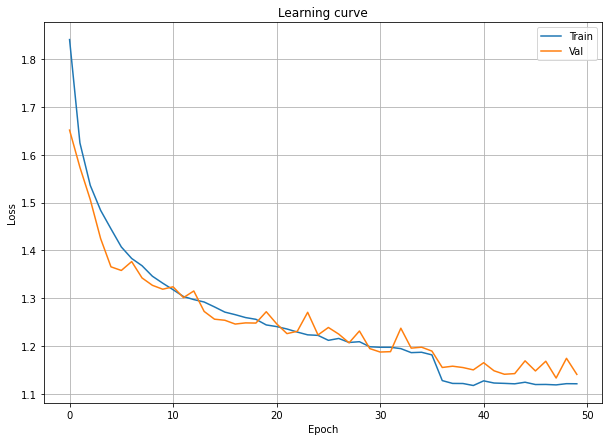

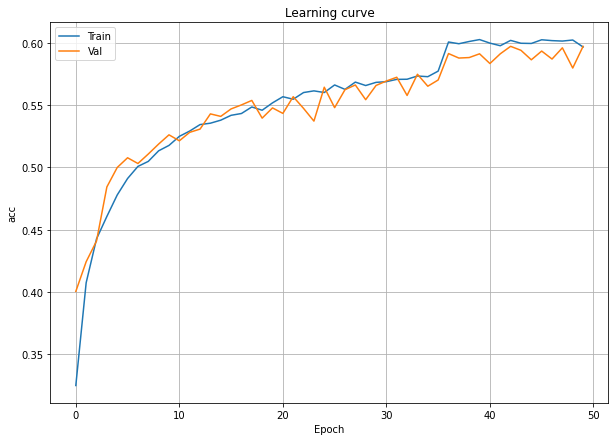

In [ ]:
plot_curves(history)

### ViT: 2 layers

In [ ]:
num_epochs = 50
embedding_dim = 128
batch_size = 128
num_blocks = 2
dropout_rate = 0.3
learning_rate = 0.001

mha_blocks = keras.Sequential(
    [ViTLayer(num_patches, embedding_dim, dropout_rate) for _ in range(num_blocks)]
)

mha_classifier = build_classifier(mha_blocks)
mha_classifier.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
data_augmentation (Sequentia (None, 64, 64, 3)         7         
_________________________________________________________________
patches_2 (Patches)          (None, 64, 192)           0         
_________________________________________________________________
dense_18 (Dense)             (None, 64, 128)           24704     
_________________________________________________________________
sequential_9 (Sequential)    (None, 64, 128)           298112    
_________________________________________________________________
global_average_pooling1d_2 ( (None, 128)               0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 128)               0   

In [ ]:
history = run_experiment(mha_classifier)

Epoch 1/50
352/352 [==============================] - 24s 58ms/step - loss: 1.7787 - acc: 0.3481 - val_loss: 1.5263 - val_acc: 0.4458
Epoch 2/50
352/352 [==============================] - 20s 57ms/step - loss: 1.5182 - acc: 0.4478 - val_loss: 1.4237 - val_acc: 0.4838
Epoch 3/50
352/352 [==============================] - 20s 57ms/step - loss: 1.4396 - acc: 0.4793 - val_loss: 1.3770 - val_acc: 0.5076
Epoch 4/50
352/352 [==============================] - 20s 57ms/step - loss: 1.3843 - acc: 0.5005 - val_loss: 1.4193 - val_acc: 0.4962
Epoch 5/50
352/352 [==============================] - 20s 57ms/step - loss: 1.3448 - acc: 0.5145 - val_loss: 1.3224 - val_acc: 0.5260
Epoch 6/50
352/352 [==============================] - 20s 57ms/step - loss: 1.3050 - acc: 0.5295 - val_loss: 1.2912 - val_acc: 0.5298
Epoch 7/50
352/352 [==============================] - 20s 57ms/step - loss: 1.2846 - acc: 0.5386 - val_loss: 1.2713 - val_acc: 0.5416
Epoch 8/50
352/352 [==============================] - 20s 57ms

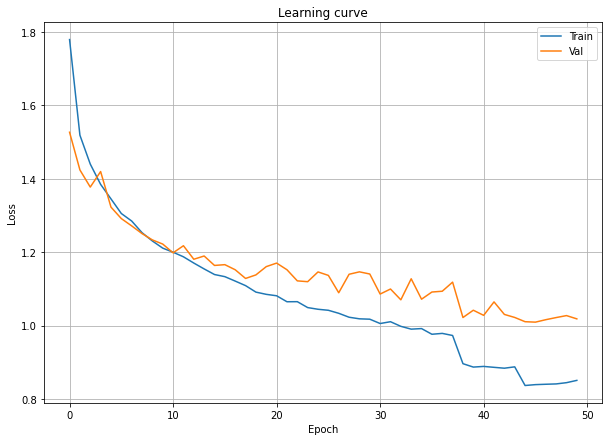

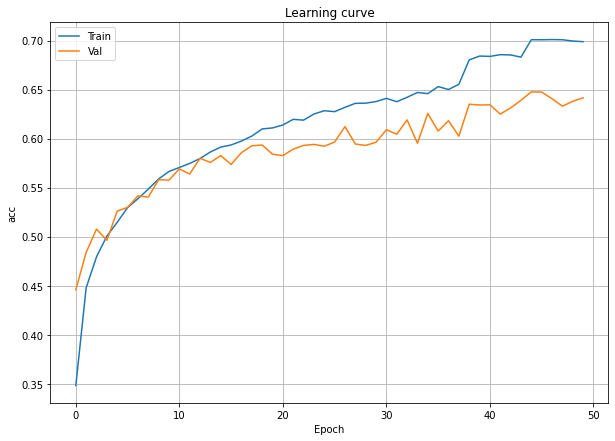

In [ ]:
plot_curves(history)

## Hybrid MLP-Mixer and ViT 

### Hybrid 1 MLP-Mixer + 1 ViT


In [ ]:
num_epochs = 50
embedding_dim = 128
batch_size = 128
dropout_rate = 0.4
learning_rate = 0.001

mlpmha_blocks = keras.Sequential(
            [
                MLPMixerLayer(num_patches, embedding_dim, dropout_rate),
                ViTLayer(num_patches, embedding_dim, dropout_rate),
            ]
        )


mlpmha_classifier = build_classifier(mlpmha_blocks)
mlpmha_classifier.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
data_augmentation (Sequentia (None, 64, 64, 3)         7         
_________________________________________________________________
patches_7 (Patches)          (None, 64, 192)           0         
_________________________________________________________________
dense_70 (Dense)             (None, 64, 128)           24704     
_________________________________________________________________
sequential_35 (Sequential)   (None, 64, 128)           174208    
_________________________________________________________________
global_average_pooling1d_7 ( (None, 128)               0         
_________________________________________________________________
dropout_43 (Dropout)         (None, 128)               0   

In [ ]:
history = run_experiment(mlpmha_classifier)

Epoch 1/50
352/352 [==============================] - 19s 45ms/step - loss: 1.8234 - acc: 0.3266 - val_loss: 1.6053 - val_acc: 0.4124
Epoch 2/50
352/352 [==============================] - 15s 44ms/step - loss: 1.5437 - acc: 0.4312 - val_loss: 1.4340 - val_acc: 0.4812
Epoch 3/50
352/352 [==============================] - 15s 44ms/step - loss: 1.4231 - acc: 0.4805 - val_loss: 1.4167 - val_acc: 0.4898
Epoch 4/50
352/352 [==============================] - 15s 44ms/step - loss: 1.3499 - acc: 0.5099 - val_loss: 1.3526 - val_acc: 0.5068
Epoch 5/50
352/352 [==============================] - 15s 44ms/step - loss: 1.2916 - acc: 0.5293 - val_loss: 1.2668 - val_acc: 0.5440
Epoch 6/50
352/352 [==============================] - 15s 44ms/step - loss: 1.2472 - acc: 0.5509 - val_loss: 1.2641 - val_acc: 0.5448
Epoch 7/50
352/352 [==============================] - 15s 44ms/step - loss: 1.2104 - acc: 0.5641 - val_loss: 1.2611 - val_acc: 0.5556
Epoch 8/50
352/352 [==============================] - 15s 44ms

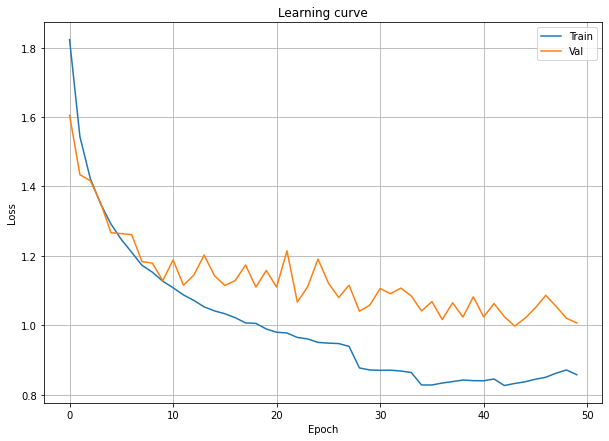

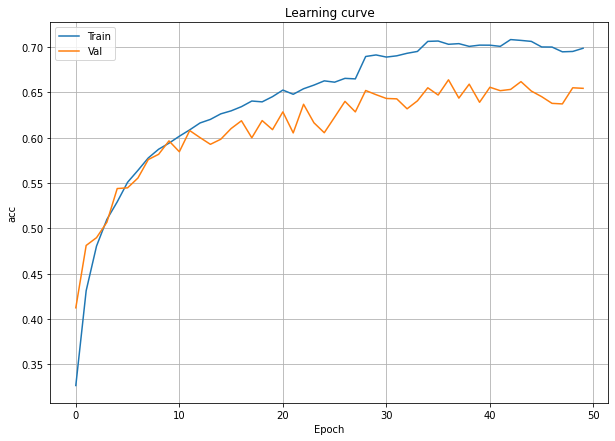

In [ ]:
plot_curves(history)

### Hybrid 2 MLP-Mixer + 1 ViT



In [ ]:
num_epochs = 50
embedding_dim = 128
batch_size = 128
dropout_rate = 0.4
learning_rate = 0.001

mlpmha_blocks = keras.Sequential(
            [
                MLPMixerLayer(num_patches, embedding_dim, dropout_rate),
                MLPMixerLayer(num_patches, embedding_dim, dropout_rate),
                ViTLayer(num_patches, embedding_dim, dropout_rate),
            ]
        )


mlpmha_classifier = build_classifier(mlpmha_blocks)
mlpmha_classifier.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
data_augmentation (Sequentia (None, 64, 64, 3)         7         
_________________________________________________________________
patches_6 (Patches)          (None, 64, 192)           0         
_________________________________________________________________
dense_62 (Dense)             (None, 64, 128)           24704     
_________________________________________________________________
sequential_31 (Sequential)   (None, 64, 128)           199360    
_________________________________________________________________
global_average_pooling1d_6 ( (None, 128)               0         
_________________________________________________________________
dropout_38 (Dropout)         (None, 128)               0   

In [ ]:
history = run_experiment(mlpmha_classifier)

Epoch 1/50
352/352 [==============================] - 26s 61ms/step - loss: 1.7909 - acc: 0.3392 - val_loss: 1.6783 - val_acc: 0.4052
Epoch 2/50
352/352 [==============================] - 21s 59ms/step - loss: 1.5090 - acc: 0.4472 - val_loss: 1.4102 - val_acc: 0.4914
Epoch 3/50
352/352 [==============================] - 21s 59ms/step - loss: 1.3893 - acc: 0.4922 - val_loss: 1.3277 - val_acc: 0.5168
Epoch 4/50
352/352 [==============================] - 21s 59ms/step - loss: 1.3106 - acc: 0.5233 - val_loss: 1.2599 - val_acc: 0.5478
Epoch 5/50
352/352 [==============================] - 21s 59ms/step - loss: 1.2462 - acc: 0.5518 - val_loss: 1.2492 - val_acc: 0.5624
Epoch 6/50
352/352 [==============================] - 21s 59ms/step - loss: 1.2048 - acc: 0.5662 - val_loss: 1.2378 - val_acc: 0.5734
Epoch 7/50
352/352 [==============================] - 21s 59ms/step - loss: 1.1580 - acc: 0.5809 - val_loss: 1.1850 - val_acc: 0.5884
Epoch 8/50
352/352 [==============================] - 21s 59ms

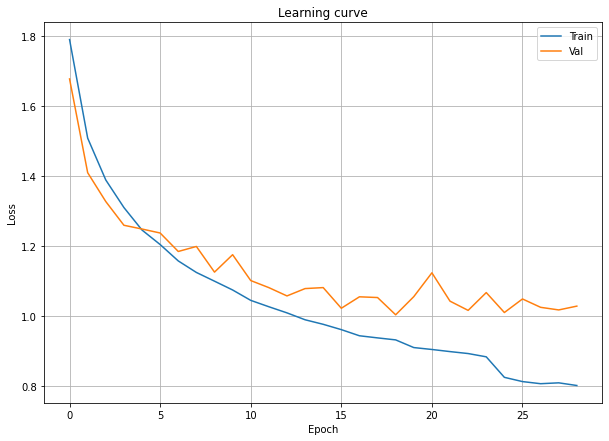

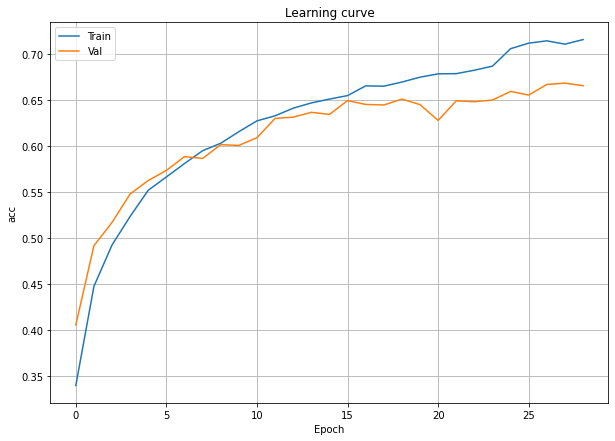

In [ ]:
plot_curves(history)